## Modified Unknown (Probabilistic) Constraint Function in Emukit
Author: Zhe Liu (Massachusetts Institute of Technology) 
Date modified: Aug 17, 2020

Version: 0.1: tested with two 2D functions - Branin and Six-hump 
- Partly modified unknown constraint function to accomodate different inputs for X and Xc
- The optimization package is not supported; only able to re-run the model iteratively with appending new data
- `ProbabilisticConstraintBayesianOptimizationLoop` is the modified unknow constraint loop

In [1]:
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
from typing import Union
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, ProbabilityOfFeasibility, ProbabilityOfImprovement
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization import AcquisitionOptimizerBase
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.parameter_space import ParameterSpace
from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition
from emukit.bayesian_optimization.local_penalization_calculator import LocalPenalizationPointCalculator

np.random.seed(4)

class ProbabilisticConstraintBayesianOptimizationLoop(OuterLoop):
    def __init__(self, space: ParameterSpace, model_objective: Union[IModel, IDifferentiable],
                 model_constraint: Union[IModel, IDifferentiable], acquisition: Acquisition = None,
                 update_interval: int = 1, batch_size: int = 1):

        """
        Emukit class that implements a loop for building Bayesian optimization with an unknown constraint.
        For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param space: Input space where the optimization is carried out.
        :param model_objective: The model that approximates the underlying objective function
        :param model_constraint: The model that approximates the unknown constraints
        :param acquisition: The acquisition function for the objective function (default, EI).
        :param update_interval:  Number of iterations between optimization of model hyper-parameters. Defaults to 1.
        :param batch_size: How many points to evaluate in one iteration of the optimization loop. Defaults to 1.
        """

#         if not np.all(np.isclose(model_objective.X, model_constraint.X)):
#             raise ValueError('Emukit currently only supports identical '
#                              'training inputs for the constrained and objective model')

        if acquisition is None:
            acquisition = ExpectedImprovement(model_objective)
 
        acquisition_constraint = ProbabilityOfFeasibility(model_constraint)

        acquisition_constrained = acquisition * acquisition_constraint

        model_updater_objective = FixedIntervalUpdater(model_objective, update_interval)
        model_updater_constraint = FixedIntervalUpdater(model_constraint, update_interval,
                                                        lambda state: state.Y_constraint)

        acquisition_optimizer = GradientAcquisitionOptimizer(space)
        if batch_size == 1:
            candidate_point_calculator = SequentialPointCalculator(acquisition_constrained, acquisition_optimizer)
        else:
            log_acquisition = LogAcquisition(acquisition_constrained)
            candidate_point_calculator = LocalPenalizationPointCalculator(log_acquisition, acquisition_optimizer,
                                                                          model_objective, space, batch_size)
        loop_state = create_loop_state(model_objective.X, model_objective.Y)

        super(ProbabilisticConstraintBayesianOptimizationLoop, self).__init__(candidate_point_calculator,
                                                                    [model_updater_objective, model_updater_constraint],
                                                                    loop_state)
    def suggest_next_locations(self):
        return self.candidate_point_calculator.compute_next_points(self.loop_state)
    
#     def acquisition_evaluate(self, X: loop_sate.X):
#         return acquisition.evaluate(X), acquisition_constraint.evaluate(X), acquisition_constrained.evaluate(X)


In [2]:
# import seaborn as sns
# sns.set(font_scale=1.1)
# sns.set_style("ticks",{'xtick.direction': 'in','ytick.direction':'in','xtick.top': True,'ytick.right': True})
def plot_acquisitions(param_bound,  f_cons_acq, f_raw_acq, f_cons_pr, X, Xc, Xnew):
    xy = []
    n_steps = 30
    for x in np.linspace(param_bound[0][0], param_bound[0][1], n_steps):
        for y in np.linspace(param_bound[1][0], param_bound[1][1], n_steps):
            xy.append([x,y])
    z1 = f_cons_acq(np.array(xy))
    z2 = f_raw_acq(np.array(xy))
    z3 = f_cons_pr(np.array(xy))

    xc = np.array(xy)[:,0].reshape(n_steps, n_steps)
    yc = np.array(xy)[:,1].reshape(n_steps, n_steps)
    zc1 = np.array(z1).reshape(n_steps, n_steps)
    zc2 = np.array(z2).reshape(n_steps, n_steps)
    zc3 = np.array(z3).reshape(n_steps, n_steps)
    
    fontsize = 12
    title_pad = 15
    fig,axes = plt.subplots(1, 3, figsize=(10, 3), sharey = False)
    c_plt1 = axes[0].contourf(xc, yc, zc1, cmap='plasma')
    fig.colorbar(c_plt1, ax= axes[0])
    axes[0].scatter(X[:,0],X[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'white')
    axes[0].scatter(Xnew[:,0],Xnew[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'green')
    axes[0].set_title('Constrained Acquisition', fontsize=fontsize,pad = title_pad)


    c_plt2 = axes[1].contourf(xc, yc, zc2, cmap='plasma')
    fig.colorbar(c_plt2, ax= axes[1])
    axes[1].scatter(X[:,0],X[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'white')
    axes[1].scatter(Xnew[:,0],Xnew[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'green')
    axes[1].set_title('Raw Acquisition', fontsize=fontsize, pad = title_pad)

    c_plt3 = axes[2].contourf(xc, yc, zc3, np.arange(0,1.01,0.1), cmap='plasma')
    fig.colorbar(c_plt3, ax= axes[2])
    axes[2].scatter(Xc[:,0],Xc[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'white')
    axes[2].scatter(Xnew[:,0],Xnew[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'green')
    axes[2].set_title('Probabilistic Constraint', fontsize=fontsize, pad = title_pad)

    for i in range(len(axes)):
        axes[i].set_xlabel(obj_fcn+'_X1',fontsize=fontsize)
        axes[i].set_ylabel(obj_fcn+'_X2',fontsize=fontsize)
    fig.tight_layout()
    plt.show()

In [3]:
# import seaborn as sns
# sns.set(font_scale=1.5)
# sns.set_style("ticks",{'xtick.direction': 'in','ytick.direction':'in','xtick.top': True,'ytick.right': True})
def plot_gp_functions(param_bound, f_obj, f_cons, X, Xc, Xnew):

    xy = []
    n_steps = 50
    for x in np.linspace(param_bound[0][0], param_bound[0][1], n_steps):
        for y in np.linspace(param_bound[1][0], param_bound[1][1], n_steps):
            xy.append([x,y])
    z1_mean, z1_var = f_obj(np.array(xy))
    z2_mean, z2_var = f_cons(np.array(xy))

    xc = np.array(xy)[:,0].reshape(n_steps, n_steps)
    yc = np.array(xy)[:,1].reshape(n_steps, n_steps)
    zc1_mean = np.array(z1_mean).reshape(n_steps, n_steps)
    zc2_mean = np.array(z2_mean).reshape(n_steps, n_steps)
    zc1_var = np.array(z1_var).reshape(n_steps, n_steps)
    zc2_var = np.array(z2_var).reshape(n_steps, n_steps)
    
    fontsize = 12
    title_pad = 15
    for zc1, zc2, label in zip([zc1_mean, zc1_var],[zc2_mean, zc2_var],['Mean', 'Variance']):
        fig,axes = plt.subplots(1, 2, figsize=(7, 3), sharey = False)
        
        c_plt1 = axes[0].contourf(xc, yc, zc1, cmap='plasma')
        fig.colorbar(c_plt1, ax= axes[0])
        axes[0].scatter(X[:,0],X[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'white')
        axes[0].scatter(Xnew[:,0],Xnew[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'green')

        axes[0].set_title('Objective Function - '+label, fontsize=fontsize, pad=title_pad)


        c_plt2 = axes[1].contourf(xc, yc, zc2, cmap='plasma')
        fig.colorbar(c_plt2, ax= axes[1])
        axes[1].scatter(Xc[:,0],Xc[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'white')
        axes[1].scatter(Xnew[:,0],Xnew[:,1], s = 30, facecolors='none', alpha = 1, edgecolor = 'green')
        axes[1].set_title('Constrained Function - '+label, fontsize=fontsize, pad=title_pad)


        for i in range(len(axes)):
            axes[i].set_xlabel(obj_fcn+' X1',fontsize=fontsize)
            axes[i].set_ylabel(obj_fcn+' X2',fontsize=fontsize)
        fig.tight_layout()
        plt.show()

In [4]:
# import seaborn as sns
# sns.set(font_scale=1.5)
# sns.set_style("ticks",{'xtick.direction': 'in','ytick.direction':'in','xtick.top': True,'ytick.right': True})
def plot_true_functions(param_bound, f_obj, f_cons):

    xy = []
    n_steps = 200
    for x in np.linspace(param_bound[0][0], param_bound[0][1], n_steps):
        for y in np.linspace(param_bound[1][0], param_bound[1][1], n_steps):
            xy.append([x,y])
    z1_mean = f_obj(np.array(xy))
    z2_mean = f_cons(np.array(xy))

    xc = np.array(xy)[:,0].reshape(n_steps, n_steps)
    yc = np.array(xy)[:,1].reshape(n_steps, n_steps)
    zc1 = np.array(z1_mean).reshape(n_steps, n_steps)
    zc2 = np.array(z2_mean).reshape(n_steps, n_steps)

    
    fontsize = 12
    title_pad = 15

    fig,axes = plt.subplots(1, 2, figsize=(7, 3), sharey = False)

    c_plt1 = axes[0].contourf(xc, yc, zc1, cmap='plasma')
    fig.colorbar(c_plt1, ax= axes[0])
    axes[0].set_title('Objective Function', fontsize=fontsize, pad=title_pad)


    c_plt2 = axes[1].contourf(xc, yc, zc2, cmap='plasma')
    fig.colorbar(c_plt2, ax= axes[1])
    axes[1].set_title('Constrained Function', fontsize=fontsize, pad=title_pad)


    for i in range(len(axes)):
        axes[i].set_xlabel(obj_fcn+' X1',fontsize=fontsize)
        axes[i].set_ylabel(obj_fcn+' X2',fontsize=fontsize)
    fig.tight_layout()
    plt.show()

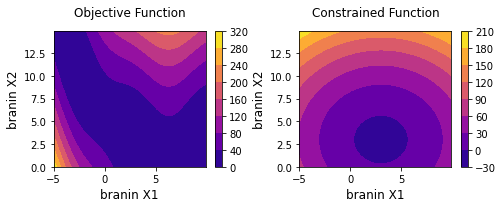

In [5]:
import GPy
from GPy.models import GPRegression

import matplotlib.pyplot as plt
import numpy as np
# Test Functions
from emukit.test_functions import sixhumpcamel_function, branin_function

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

# Model Wrappers
from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy
import warnings
#warnings.filterwarnings('ignore')

# Decision loops 
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      MultipointExpectedImprovement,\
                                                      ProbabilityOfFeasibility

from emukit.core.acquisition import IntegratedHyperParameterAcquisition
from emukit.experimental_design.acquisitions import ModelVariance
# Acquistions optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer
# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition
from emukit.core import ParameterSpace, DiscreteParameter

### Define the objective function
### In this case we use the Branin function available in Emukit.
obj_fcn = 'branin'
if obj_fcn == 'six_hump':
    f, parameter_space = sixhumpcamel_function()
    def fc(x):#sixhumpcamel constraints
        return np.transpose([((x[:,0]-0.1)**2+(x[:,1]+0.6)**2-0.16)])+(np.random.random(1)-0.5)/10
elif obj_fcn == 'branin':
    f, parameter_space = branin_function()
    parameter_space = ParameterSpace([DiscreteParameter('branin X1', np.arange(-5,10, 0.1)),
                                    DiscreteParameter('branin X2', np.arange(0,15, 0.1))])
    def fc(x):    #branin constraints 
        return np.transpose([((x[:,0]-3)**2+(x[:,1]-3)**2-9)])+(np.random.random(1)-0.5)*4
else:
    raise ValueError('Need to either define an objective function and its constraint functions'
                     'Or, use external X and Y inputs iteratively')

plot_true_functions(parameter_space.get_bounds(), f, fc)
#print(parameter_space.)

In [6]:
num_init_points = 5
#pre-sampling of objective function
design = LatinDesign(parameter_space)
x_init = design.get_samples(num_init_points)
y_init = f(x_init)

#print(x_init, y_init)

In [7]:
#pre-sampling of constraint function
num_add_cons_points = 5
xc_init = np.concatenate([x_init, design.get_samples(num_add_cons_points)])
yc_init = fc(xc_init)

#print(xc_init, yc_init)

In [8]:
#print(X,Y)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
 /opt/anaconda3/envs/perovskite/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /opt/anaconda3/envs/perovskite/lib/python3.10/site-packages/emukit/bayesian_optimization/acquisitions/log_acquisition.py:25: RuntimeWarning:divide by zero encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total sample no. 10


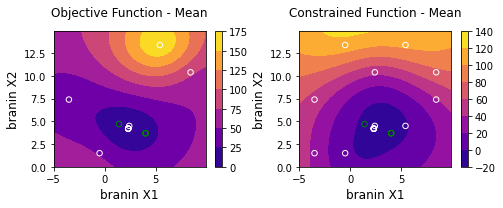

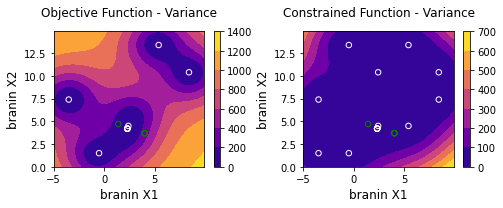

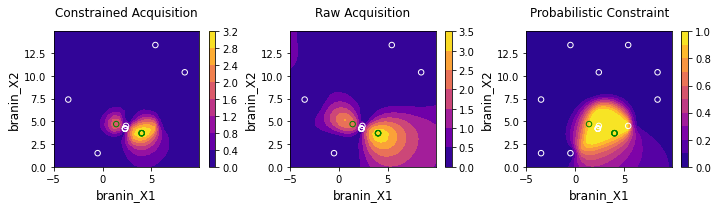

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total sample no. 20


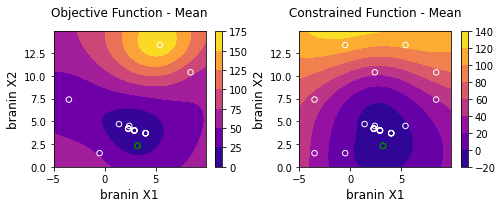

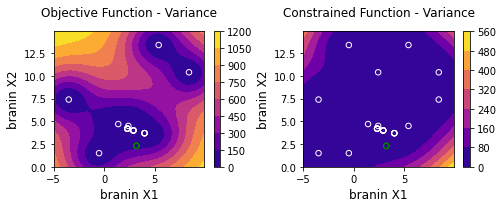

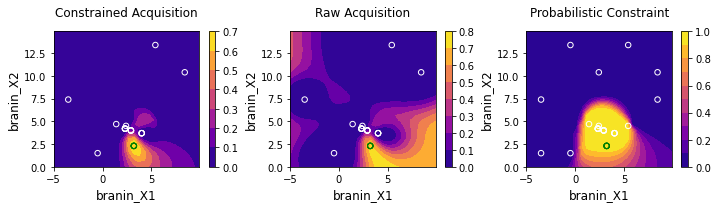

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total sample no. 30


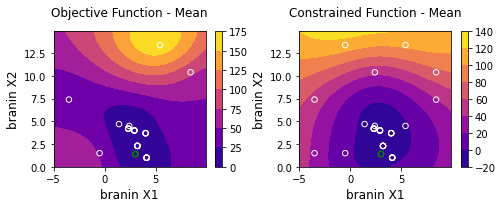

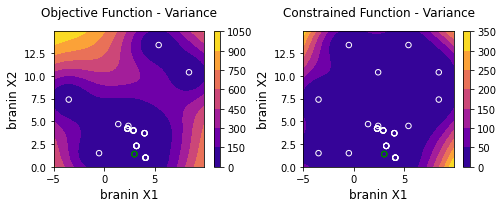

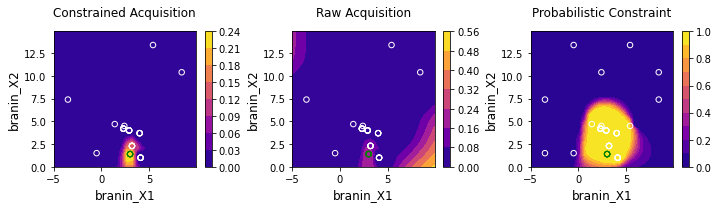

In [9]:
X, Y, Xc, Yc = [x_init, y_init, xc_init, yc_init]

acq_val, acq_fcn, acq_cons = [[],[],[]]
n_iterations = 5
batch = 5
for i in range(n_iterations+1):
    ### Fit and wrap a model to the collected data
    input_dim = len(X[0])
    ker = GPy.kern.Matern52(input_dim = input_dim, ARD =False)#
    ker.lengthscale.constrain_bounded(1e-5, 100.1)
    ker.variance.constrain_bounded(1e-5, 1000.1)
    ker += GPy.kern.Bias(input_dim = input_dim)
    model_gpy = GPRegression(X , Y, ker)
#     model_gpy.kern.set_prior(GPy.priors.Uniform(0,5))
#     model_gpy.likelihood.variance.constrain_fixed(0.1)
    model_gpy.randomize()
    model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
    objective_model = GPyModelWrapper(model_gpy)

    # Make GPy constraint model
    ker = GPy.kern.Matern52(input_dim = len(Xc[0]), ARD =False)
    ker.lengthscale.constrain_bounded(1e-5, 1000.1)
    ker.variance.constrain_bounded(1e-5, 1000.1) 
    ker += GPy.kern.Bias(input_dim = input_dim)
    gpy_constraint_model = GPRegression(Xc, Yc, ker)
    gpy_constraint_model.randomize()
    gpy_constraint_model.optimize_restarts(num_restarts=20,verbose =False, messages=False) 
    constraint_model = GPyModelWrapper(gpy_constraint_model)
    
    ## Expeceted Improvement (EI)
    acquisition = ExpectedImprovement(objective_model, jitter=.01)
    ## Lower Confidence Bound (LCB)
    #acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)

    ## fully integreated acquisition
    #     acquisition_generator = lambda m: ExpectedImprovement(m, jitter=.01)
    #     expected_improvement_integrated = IntegratedHyperParameterAcquisition(objective_model, acquisition_generator)
    #     acquisition = expected_improvement_integrated

    # Make loop and collect points
    bayesopt_cons_pr = ProbabilisticConstraintBayesianOptimizationLoop(model_objective=objective_model, 
                                                              space=parameter_space, 
                                                              acquisition=acquisition,
                                                              model_constraint=constraint_model,
                                                              batch_size = batch)
  
    X_new = bayesopt_cons_pr.candidate_point_calculator.compute_next_points(bayesopt_cons_pr.loop_state)
    
    Y_new = f(X_new) # replace by new experiment results
    Xc_new = X_new
    Yc_new = fc(X_new) # replace by new experiment results
    
    f_cons_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.evaluate
    f_raw_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_1.evaluate
    f_cons_pr = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_2.evaluate
    
    acq_product_iter = f_cons_acq(X_new)
    acq_fcn_iter = f_raw_acq(X_new)
    acq_cons_iter = f_cons_pr(X_new)
    acq_val.append(acq_product_iter)
    acq_fcn.append(acq_fcn_iter)
    acq_cons.append(acq_cons_iter)
    #print(acq_val)
    param_bound = parameter_space.get_bounds()
    f_obj =  objective_model.model.predict
    f_cons = constraint_model.model.predict
    if len(bayesopt_cons_pr.loop_state.X)%10 == 0:
        print('total sample no.', len(bayesopt_cons_pr.loop_state.X))
#         constraint_model.model.plot()
#         objective_model.model.plot()
#         plt.show()
        plot_gp_functions(param_bound, f_obj, f_cons, X, Xc, X_new)
        plot_acquisitions(param_bound, f_cons_acq, f_raw_acq, f_cons_pr, X, Xc, X_new)    
    
    X = np.concatenate([X, X_new])
    Y = np.concatenate([Y, Y_new])
    Xc = np.concatenate([Xc, Xc_new])
    Yc = np.concatenate([Yc, Yc_new])

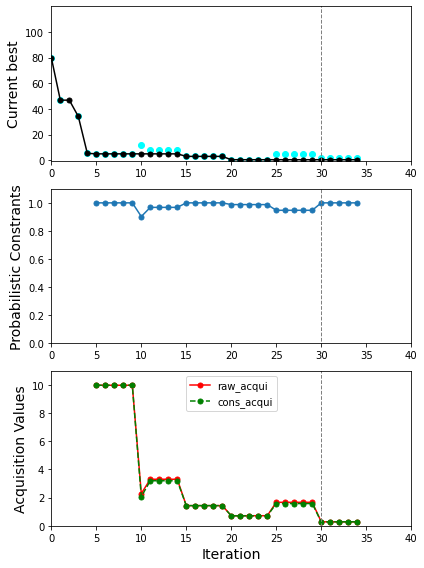

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(6,8))
font_size = 14
marker_size = 5
ax[0].plot(np.arange(len(Y)), np.minimum.accumulate(Y), 
           marker = 'o', ms = marker_size, c = 'black')
ax[0].scatter(np.arange(len(Y)), Y, c = 'cyan')

ax[0].set_ylabel('Current best', fontsize = font_size)

ax[0].set_xlim(0, len(Y)+5)
ax[0].set_ylim(min(np.minimum.accumulate(Y))-1, 
               np.max(np.minimum.accumulate(Y))+abs(np.max(np.minimum.accumulate(Y)))*0.5)

ax[1].plot(np.arange(len(Y)-num_init_points)+num_init_points, np.concatenate(acq_cons), 
          marker = 'o', ms = marker_size)
ax[1].set_ylabel('Probabilistic Constrants', fontsize = font_size)
ax[1].set_xlim(0, len(Y)+5)
ax[1].set_ylim(0, 1.1)


ax[2].plot(np.arange(len(Y)-num_init_points)+num_init_points, np.concatenate(acq_fcn), 
           marker = 'o', ms = marker_size, c = 'red', label = 'raw_acqui')
ax[2].plot(np.arange(len(Y)-num_init_points)+num_init_points, np.concatenate(acq_val),'--', 
           marker = 'o', ms = marker_size,c = 'green', label = 'cons_acqui')
ax[2].set_ylabel('Acquisition Values', fontsize = font_size)
ax[2].set_xlabel('Iteration', fontsize = font_size)
ax[2].set_xlim(0, len(Y)+5)
ax[2].set_ylim(0, np.max(acq_fcn)*1.1)
ax[2].legend()

ax[2].set_xlim(0, len(Y)+5)
fig.tight_layout()

for a in ax:
    a.plot(np.ones(1000)*(num_init_points+batch*(n_iterations)), np.arange(1000)-500, '--', linewidth = 1, color = 'gray' )

plt.show()
